# Process and map range of trigger thresholds

NB: to make multi-model NMME processing work, gotta set the boostrap draws to only non-nan values

In [1]:
import xarray as xr
from xarray.groupers import SeasonResampler
import xesmf as xe
import numpy as np
import pandas as pd 
import geopandas as gpd
import os
import glob
import re
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import matplotlib as mpl
from cartopy import crs as ccrs
import cmocean
from dask.diagnostics import ProgressBar
from numba import jit as njit
from distributed import Client

from funcs_support import get_params,get_filepaths, utility_print, utility_save
from funcs_aux import get_landmask

dir_list = get_params()

In [2]:
client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 503.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44271,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45888,Total threads: 6
Dashboard: http://127.0.0.1:46689/status,Memory: 62.92 GiB
Nanny: tcp://127.0.0.1:41538,


## Setup

In [3]:
# Trigger threshold
aa_trigger = 0.2
# Random seed for bootstraps
rng = np.random.default_rng()
# How many years / block
samp_size = 5
# How many bootstrap draws
ndraws = 1000

# Set up filepaths
df = get_filepaths()

# Variables / bootstrap dimension setup
boot_dim = 'year'
var = 'pr'

# Which data to use
# GPCP, CHIRPS, or NCEP-CFSv2 / NCEP-CFSv2-ensmean
#proc_source = 'NCEP-CFSv2-ensmean' 
proc_source = 'GPCP'

# Set output filenames
output_fns = {'threshs':dir_list['tmp']+'pr-trigger-threshs_year_'+proc_source+'.zarr',
              'seasmask':dir_list['aux']+'seasmask_CHIRPS.zarr'}

## Helper functions

In [4]:
chunk_sizes = {'NCEP-CFSv2':20,
               'NCEP-CFSv2-ensmean':40,
               'GPCP':40,
               'CHIRPS':200}

def load_data(proc_source,data = 'raw',return_loadfn = False,chunk_sizes = chunk_sizes):
    if data == 'raw':
        df = get_filepaths(source_dir = 'raw').query('varname == "pr"')
        if proc_source == 'GPCP':
            #----- For GPCP ----- 
            df_tmp = df.query('model == "GPCP"')
            fn = df_tmp.iloc[0]['path']
            ds = xr.open_dataset(fn)
            
        elif proc_source == 'CHIRPS':
            #----- For CHIRPS ----- 
            df_tmp = df.query('model == "CHIRPS" and freq == "Amon"')
            fn = df_tmp.iloc[0]['path']
            ds = xr.open_dataset(fn,chunks = {'lat':chunk_sizes[proc_source],
                                              'lon':chunk_sizes[proc_source],'time':-1})
    
        elif proc_source == 'NCEP-CFSv2':
            df_tmp = df.query('model == "NCEP-CFSv2" and freq == "Amon" and filetype == "zarr"')
            fn = df_tmp.iloc[0]['path']
            ds = xr.open_zarr(fn).isel(lead=0)
        
        elif proc_source == 'NMME':
            #----- For NMME -----
            # Will require setting model explicilty in figure code
            # AND will require changing bootstrap code to only sample from non-nan chunks
            df_tmp = df.query('exp == "hindcasts"')
            ds = xr.concat([xr.open_dataset(row[1]['path'],chunks={'lat':20,'lon':50})
                            for row in df_tmp.iterrows()],
                           dim=pd.Index([row[1]['model'] for row in df_tmp.iterrows()],
                                                       name='model'),
                            join='outer')
    elif data == 'seasavg':
        df = get_filepaths(source_dir = 'proc').query('varname == "pr" and freq == "seasavg"')
        df_tmp = df.query(f'model == "{proc_source}"')
        fn = df_tmp.iloc[0]['path']
        if df_tmp.iloc[0]['filetype'] == 'zarr':
            ds = xr.open_zarr(fn)
            ds = ds.chunk({'lat':chunk_sizes[proc_source],
                                              'lon':chunk_sizes[proc_source]})
        else:
            ds = xr.open_dataset(fn)
    else:
        raise KeyError(f'`data` input {data} not supported')


    if return_loadfn:
        return ds,fn
    else:
        return ds

@njit
def get_boot_threshs(ts, start_years, aa_trigger=aa_trigger, samp_size=samp_size):
    ''' numbaized block bootstrap quantile calculation code ''' 
    n_run, n_block = start_years.shape

    # Create empty 
    if ts.ndim==1:
        out = np.empty(n_run,dtype=ts.dtype)
    else:
        out = np.empty((ts.shape[1],n_run),dtype=ts.dtype)
    
    # Process by run
    if not np.all(np.isnan(ts)):
        for run_idx in range(n_run):
            if ts.ndim == 1:
                draws = np.empty((n_block, samp_size), dtype=ts.dtype)
                for b in range(n_block):
                    sy = start_years[run_idx, b]
                    draws[b, :] = ts[sy:sy + samp_size]
                out[run_idx] = np.quantile(draws, aa_trigger)
            
            else:
                for idv_idx in range(ts.shape[1]):
                    draws = np.empty((n_block, samp_size), dtype=ts.dtype)
                    for b in range(n_block):
                        sy = start_years[run_idx, b]
                        draws[b, :] = ts[sy:sy + samp_size,idv_idx]
                    out[idv_idx,run_idx] = np.quantile(draws, aa_trigger)
    else:
        out = out*np.nan

    return out

def boot_threshs_block(ds,var='pr',boot_dim = 'year',
                       aa_trigger = aa_trigger, samp_size = samp_size):
    ''' quantile calculation of block bootstrap samples, optimized for xr.map_blocks() 

    Parameters
    ---------------
    ds : xr.Dataset
        Dataset containing both `var` (below) _and_ 
        `start_years`, a `draw` x `block` datarray
        giving the indices of the start years of 
        each bootstrap block

    var : str, by default 'pr'
        The variable in `ds` to process

    boot_dim : str, by default 'year'
        The dimension of `var` across which to bootstrap

    aa_trigger : float
        The quantile to calculate (e.g., 0.2)

    samp_size : int
        The bootstrap block size (e.g., 5)

    Returns
    ---------------
    threshs : xr.DataArray
        The quantiles 
    
    
    '''
    #print(
    #    "BLOCK SHAPES:",
    #    {k: v.shape for k, v in ds.data_vars.items()},
    #    flush=True,
    #)
    # Transpose main variable ensure correct orders for numba / 
    # raw numpy below
    main_dim_order = ['lat','lon',boot_dim]
    other_dims = [dim for dim in ds[var].dims if dim not in main_dim_order]
    ds[var] = ds[var].transpose(*main_dim_order,*other_dims)

    #print('1. '+str(ds.sizes))

    # Stack dimensions that aren't lat, lon, and the 
    # dimension to bootstrap over, to make np.quantile
    # work in numba (the axis argument isn't supported)
    if len(other_dims)>1:
        ds = ds.stack(idv = other_dims)
        stacked = True
    else:
        stacked = False
    #print('2. '+str(ds.sizes))
        
    # Transpose start years to ensure correct orders
    # for numba / raw numpy below
    ds['start_years'] = ds['start_years'].transpose('draw','block')

    # Create empty array for output
    if len(other_dims)==0:
        threshs = np.empty((ds.sizes['lat'], ds.sizes['lon'], ds.sizes['draw']), dtype=ds[var].dtype)
    else:
        # (flexible, since it's only "idv" in the case of more than one "other_dim",
        # otherwise, it's the original name of that dimension)
        odim_name = [dim for dim in ds[var].dims if dim not in main_dim_order][0]
        threshs = np.empty((ds.sizes['lat'],ds.sizes['lon'],ds.sizes[odim_name],ds.sizes['draw']),
                       dtype=ds[var].dtype)

    # Run block bootstrap threshold calculation
    for i in range(ds.sizes['lat']):
        for j in range(ds.sizes['lon']):
            ts = ds[var].isel(lat=i,lon=j).values

            threshs[i,j,:] = get_boot_threshs(ts,ds.start_years.values)

    # Assign to ds to allow unstacking, if necessary
    if len(other_dims) == 0:
        ds['threshs'] = (('lat','lon','draw'),threshs)
    else:
        ds['threshs'] = (('lat','lon',odim_name,'draw'),threshs)

    # Unstack, if necessary
    if stacked:
        out_da = ds['threshs'].unstack()
    else:
        out_da = ds['threshs']

    out_da = out_da.transpose('lat','lon',*other_dims,'draw')

    #print(
    #    "OUTPUT SIZES:",
    #    out_da.sizes,
    #    flush=True,
    #)

    
    return out_da

## Calculate trigger thresholds

In [5]:
if not os.path.exists(output_fns['threshs']):
    # Load data
    ds,fn = load_data(proc_source,return_loadfn=True)

    #-------------------------
    # Get seasonal means
    #-------------------------
    fn_seasmeans = re.sub(r'\_Amon\_','_seasavg_',re.sub(dir_list['raw'],dir_list['proc'],fn))
    
    if not os.path.exists(fn_seasmeans):
        dsm = ds.groupby(
            time=SeasonResampler(["DJF", "MAM", "JJA", "SON"], drop_incomplete=True)
        ).mean()
        
        # Unstack into season x year
        dsm['season'] = dsm.time.dt.season
        dsm['year'] = dsm.time.dt.year
        dsm = dsm.set_index(time=['season','year']).unstack()
        
        dsm = dsm.chunk({'season':-1,'year':-1,'lat':250,'lon':250})
    
        dsm.attrs = {'SOURCE':'map_thresh.ipynb',
                     'DESCRIPTION':'3-month seasonal means'}
        
        utility_save(dsm.drop_encoding(),fn_seasmeans)
    else:
        dsm = xr.open_zarr(fn_seasmeans)


    #-------------------------
    # Calculate triggers for each bootstrap run 
    #-------------------------
    # Generate starting years of bootstrap blocks
    start_years = xr.DataArray(rng.integers(0,dsm.sizes['year'] - samp_size,
                               (ndraws,np.ceil(dsm.sizes['year']/samp_size).astype(int))),
                               dims=['draw','block'])

    dsm = xr.merge([dsm,
          start_years.to_dataset(name='start_years')])
    # Chunk to ensure map_blocks works on individual chunks, 
    # i.e., across lat/lon, with other dimensions (especially
    # the year dimension) being in one piece
    dsm = dsm.chunk({'lat':chunk_sizes[proc_source],'lon':chunk_sizes[proc_source],
                     **{k:-1 for k in dsm.dims if k not in ['lat','lon']}})

    # Template to tell xr.map_blocks what size array to expect
    template = (dsm[var].isel({boot_dim:0},drop=True)*np.nan).expand_dims({'draw':ndraws},
                                                    axis = ds[var].ndim-1)
    template = template.transpose('lat','lon',*[dim for dim in template.dims if dim not in ['lat','lon','draw']],'draw')

    # Map blocks
    threshs = xr.map_blocks(boot_threshs_block,
                            dsm,
                            template=template,
    )
    threshs = threshs.to_dataset(name='triggthresh')

    #-------------------------
    # Calculate stats of triggers across bootstrap runs 
    #-------------------------
    # Get range of threshholds
    threshs['triggiqr'] = threshs['triggthresh'].quantile(0.975,dim='draw') - threshs['triggthresh'].quantile(0.025,dim='draw')
    threshs['triggiqr'].attrs['long_name'] = '95% IQR of trigger thresholds across runs'
    
    # Get means for reference
    threshs['threshmean'] = threshs['triggthresh'].mean('draw')
    threshs['threshmean'].attrs['long_name'] = 'Mean of trigger thresholds across runs'
    
    # Get IQR / mean precipitation
    threshs['triggiqr_cv_meanpr'] = (threshs['triggiqr'] / dsm.pr.mean('year'))
    threshs['triggiqr_cv_meanpr'].attrs['long_name'] = 'Ratio of 95% IQR of trigger thresholds to mean rainfall'
    
    # IQR / mean trigger
    threshs['triggiqr_cv'] = threshs['triggiqr'] / threshs['triggthresh'].mean('draw')
    threshs['triggiqr_cv'].attrs['long_name'] = 'Ratio of 95% IQR of trigger thresholds to mean trigger threshold'
    
    # And log version of the same
    threshs['triggiqr_cv_log'] = np.log(threshs['triggiqr'])
    threshs['triggiqr_cv_log'].attrs['long_name'] = 'Log ratio of 95% IQR of trigger thresholds to mean trigger threshold'

    #-------------------------
    # Save bootstrapped trigger thresholds 
    #-------------------------
    threshs = threshs.assign_coords({'aa_thresh':([],aa_trigger)})
    threshs.attrs['SOURCE'] = 'map_thresh.ipynb'
    threshs.attrs['DESCRIPTION'] = 'AA trigger thresholds for moving-block bootstrap runs'
    threshs.attrs['nblocks'] = ndraws
    threshs.attrs['years_per_block'] = samp_size

    

    utility_save(threshs.drop_encoding(),output_fns['threshs'])
else:
    threshs = xr.open_zarr(output_fns['threshs'])#.load()
    print(output_fns['threshs']+' exists, loaded!')

/dx06/data/aux_joint/pr-trigger-threshs_year_GPCP.zarr exists, loaded!


## Plot figures

In [6]:
# Get landmask
landmask = get_landmask(threshs,lm_source='ne110')

# Get country borders
gdf = gpd.read_file(dir_list['aux']+'geo_data/ne_10m_admin_0_countries_iso/ne_10m_admin_0_countries_iso.shp')

lat/lon bounds not found in dataset; they will be created.


In [7]:
## TRANSFER SEASONAL THRESHOLDS INTO A SEASONAL MASK 
# using CHIRPS
if not os.path.exists(output_fns['seasmask']):
    # Load seasonal thresholds
    ds_seas = xr.open_zarr(dir_list['proc']+'CHIRPS/prseasstats_doyavg_CHIRPS_historical_obs_1981010101-20250930.zarr')
    
    # One non-leap reference year (matches pandas/xarray season logic)
    ts = xr.DataArray(
        pd.date_range('2001-01-01', '2001-12-31'),
        dims=['time'],
    )
    
    # dayofyear coordinate: 1..365
    doy = ts.dt.dayofyear
    season = ts.dt.season
    
    def seasonal_fraction(onset, demise, season_doy_mask):
        """
        Fraction of climatological season covered by a rainy season.
    
        onset, demise : DataArray (DOY)
        season_doy_mask : DataArray(dayofyear) bool
        """
        season_days = doy.where(season_doy_mask, drop=True)
        n_season_days = season_days.size
    
        # Broadcast DOY to lat/lon grid
        doy_3d = season_days.broadcast_like(onset)
    
        # Non-wrapping rainy season
        normal = onset <= demise
        in_rainy_normal = (doy_3d >= onset) & (doy_3d <= demise)
    
        # Wrapping rainy season (e.g. Nov–Feb)
        in_rainy_wrap = (doy_3d >= onset) | (doy_3d <= demise)
    
        in_rainy = xr.where(normal, in_rainy_normal, in_rainy_wrap)
    
        # Count overlapping days
        overlap_days = in_rainy.sum('time')
    
        return overlap_days / n_season_days
    
        
    
    out = []
    
    seas_frac_thresh = 0.2
    
    for s in ['DJF','MAM','JJA','SON']:
        season_mask = season == s
    
        frac = seasonal_fraction(
            onset=ds_seas.onset,
            demise=ds_seas.demise,
            season_doy_mask=season_mask,
        )
    
        # If either rainy season satisfies the threshold → True
        active = (frac >= seas_frac_thresh).any("season")
    
        active = active.assign_coords(season=s).expand_dims("season")
        out.append(active)
    
    active_seasons = xr.concat(out, dim="season").compute()

    #-------------------------
    # Output temporary file 
    #-------------------------
    active_seasons.attrs['SOURCE'] = 'map_thresh.ipynb'
    active_seasons.attrs['DESCRIPTION'] = ('boolean for if a location, in the climatological average for CHIRPS, '+
                                           'a given 3-month period overlaps with a local rainy season (defined as '+
                                           'taking up more than `seas_thresh` fraction of the 3-month period, using '+
                                           'the onset / demise calculated using the Dunning et al. (2017) methodology.'
                                          )
    active_seasons.attrs['seas_thresh'] = str(seas_frac_thresh)

    active_seasons = active_seasons.to_dataset(name='seasmask')

    utility_save(active_seasons,output_fns['seasmask'])
else:
    active_seasons = xr.open_zarr(output_fns['seasmask']).load()
    print(output_fns['seasmask']+' exists, loaded!')
    

/home/kschwarz/projects/forecast_uncertainty/aux_data/seasmask_CHIRPS.zarr exists, loaded!


In [8]:
# Regrid seasonmask to trigger threshold grid
rgrd = xe.Regridder(active_seasons,threshs,'conservative')
active_seasons_rg = rgrd(active_seasons)
active_seasons_rg = active_seasons_rg.sel(lat=threshs.lat.values)

In [25]:
#-------------------------------------
# Get threshold-based dry season mask
#-------------------------------------
seas_thresh = 0.5 # mm/day

# Load data
dsm = load_data(proc_source,data='seasavg')

# Get boolean mask for threshold exceedence
dry_thresh = dsm.pr.mean('year')>seas_thresh



/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_maps.pdf saved!
/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_maps.png saved!


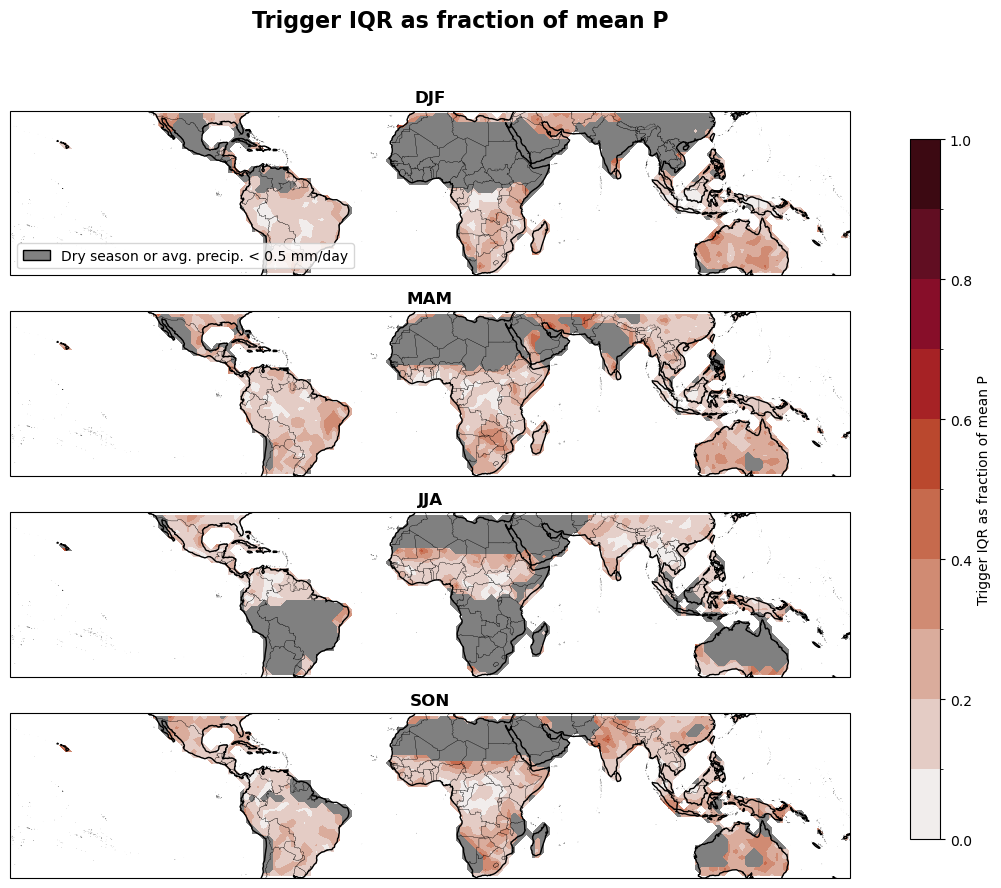

In [26]:
seas_thresh = 0.5 # mm/day

fig = plt.figure(figsize=(12,10))

var = 'triggiqr_cv_meanpr'

cbar_params = {'triggiqr':{'vmin':0,'vmax':5,'cmap':cmocean.cm.amp,'levels':11},
               'triggiqr_cv_log':{'vmin':-1,'vmax':1,'cmap':mpl.colormaps['berlin'],'levels':11},
               'triggiqr_cv_meanpr':{'vmin':0,'vmax':1,'cmap':cmocean.cm.amp,'levels':11}}

labels = {'triggiqr':'IQR of bootstrapped trigger thresholds [mm/day]',
          'triggiqr_cv_log':'IQR / Mean of bootstrapped trigger thresholds',
          'triggiqr_cv_meanpr':'Trigger IQR as fraction of mean P'}


subset_params = {'lat':slice(-35,35),'lon':slice(-180,180)}

for seas_idx,seas in enumerate(['DJF','MAM','JJA','SON']):
    ax = plt.subplot(4,1,seas_idx+1,projection=ccrs.PlateCarree())

    plot_data = threshs[var].sel(season=seas,**subset_params)
    # Subset to land only
    plot_data = plot_data.where(landmask)

    # Plot
    plot_data.plot.contourf(transform=ccrs.PlateCarree(),**cbar_params[var],
                            add_colorbar=False)

    # Grey out regions without an active rainy season or that are generally 
    # too dry
    season_mask = (active_seasons_rg.seasmask.sel(season=seas,**subset_params) & 
                   dry_thresh.sel(season=seas)).where(landmask)
    season_mask.plot.contourf(levels=[-0.5, 0.5, 1.5],
                                 colors=['grey','none'],
                                 hatches=[None, None],
                                 transform=ccrs.PlateCarree(),
                                 add_colorbar=False)

    ax.coastlines()
    ax.set_title(seas,fontweight='bold',fontsize=12)
    
    # Country borders
    # Add to plot (subset_params in slice format)
    gdf.cx[subset_params['lon'],subset_params['lat']].plot(ax=ax,facecolor='none',edgecolor='k',
                                                       linestyle='-',linewidth=0.15,
                                                       transform=ccrs.PlateCarree())
    ax.set_extent([subset_params['lon'].start,
                   subset_params['lon'].stop,
                   subset_params['lat'].start,
                   subset_params['lat'].stop])

    if seas_idx == 0:
        ax.legend(handles=[mpatches.Patch(facecolor='grey',edgecolor='k',
                                          label=f'Dry season or avg. precip. < {str(seas_thresh)} mm/day')],loc='lower left')

fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params[var]['levels']).tick_values(cbar_params[var]['vmin'],cbar_params[var]['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params[var]['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params[var]['cmap'],norm=norm)
plt.colorbar(sm,cax=cax,label=labels[var])


plt.suptitle(labels[var],fontweight='bold',fontsize=16)

utility_print(dir_list['figs']+proc_source+'_maps')

## Decadal variability figure

In [27]:
#-------------------------
# Get var of decadal means
#-------------------------
dsm = load_data(proc_source,data = 'seasavg')

# Get SD of 10-year-rolling-mean
decvar = dsm.pr.rolling(year=10).mean().std('year')
decvar = decvar.to_dataset(name='decvar')

# Get SD scaled by mean rainfall
decvar['decvar_cv'] = decvar.decvar / dsm.pr.mean('year')

/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_decvar_cv_maps.pdf saved!
/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_decvar_cv_maps.png saved!


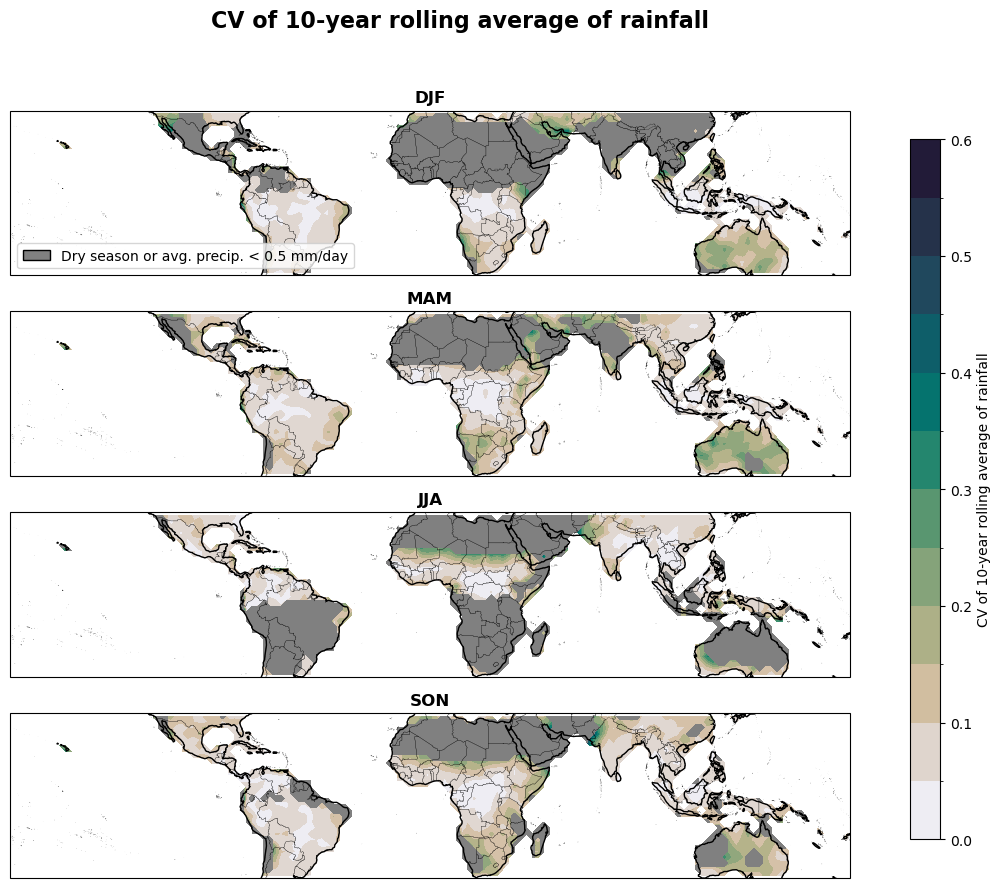

In [31]:
seas_thresh = 0.5 # mm/day

fig = plt.figure(figsize=(12,10))

subset_params = {'lat':slice(-35,35),'lon':slice(-180,180)}

var = 'decvar_cv'
cbar_params = {'decvar':{'vmin':0,'vmax':2,'cmap':cmocean.cm.rain,'levels':11},
               'decvar_cv':{'vmin':0,'vmax':0.6,'cmap':cmocean.cm.rain,'levels':13}}
labels = {'decvar':'Std of 10-year rolling average of rainfall',
          'decvar_cv':'CV of 10-year rolling average of rainfall'}

output_fn = dir_list['figs']+proc_source+'_'+var+'_maps'
save_fig = True

for seas_idx,seas in enumerate(['DJF','MAM','JJA','SON']):
    ax = plt.subplot(4,1,seas_idx+1,projection=ccrs.PlateCarree())

    plot_data = decvar[var].sel(season=seas,**subset_params)
    # Subset to land only
    plot_data = plot_data.where(landmask)

    # Plot
    plot_data.plot.contourf(transform=ccrs.PlateCarree(),**cbar_params[var],
                            add_colorbar=False)

    # Grey out regions without an active rainy season
    season_mask = (active_seasons_rg.seasmask.sel(season=seas,**subset_params) & 
                   dry_thresh).where(landmask)
    season_mask.sel(season=seas,**subset_params).where(landmask).plot.contourf(levels=[-0.5, 0.5, 1.5],
                                                                                     colors=['grey','none'],
                                                                                     hatches=[None, None],
                                                                                     transform=ccrs.PlateCarree(),
                                                                                     add_colorbar=False)

    ax.coastlines()
    ax.set_title(seas,fontweight='bold',fontsize=12)
    
    # Country borders
    # Add to plot (subset_params in slice format)
    gdf.cx[subset_params['lon'],subset_params['lat']].plot(ax=ax,facecolor='none',edgecolor='k',
                                                       linestyle='-',linewidth=0.15,
                                                       transform=ccrs.PlateCarree())
    ax.set_extent([subset_params['lon'].start,
                   subset_params['lon'].stop,
                   subset_params['lat'].start,
                   subset_params['lat'].stop])

    if seas_idx == 0:
        ax.legend(handles=[mpatches.Patch(facecolor='grey',edgecolor='k',
                                          label=f'Dry season or avg. precip. < {str(seas_thresh)} mm/day')],loc='lower left')

fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params[var]['levels']).tick_values(cbar_params[var]['vmin'],cbar_params[var]['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params[var]['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params[var]['cmap'],norm=norm)
plt.colorbar(sm,cax=cax,label=labels[var])


plt.suptitle(labels[var],fontweight='bold',fontsize=16)

if save_fig:
    utility_print(output_fn)



## Old code

In [ ]:
@njit
def get_boot_threshs(da, start_years, aa_trigger=aa_trigger, samp_size=samp_size):
    ''' Numabized bootstrap thresholds '''
    
    # Make sure the input_core_dims order matches this
    n_run = start_years.shape[0]
    n_block = start_years.shape[1]

    threshs = np.empty(n_run, dtype=da.dtype)

    # For each bootstrap run, generate moving blocks
    for run_idx in range(n_run):
        # Preallocate draws: (blocks × samp_size)
        draws = np.empty((n_block, samp_size), dtype=da.dtype)

        for b in range(n_block):
            sy = start_years[run_idx, b]
            draws[b, :] = da[sy:sy + samp_size]

        threshs[run_idx] = np.quantile(draws, aa_trigger)

    return threshs